### Practice: Segment lungs, hearts, and clavicles
* Using UNet

In [1]:
import cv2
import os

In [2]:
from imutils import paths
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from torchmetrics import JaccardIndex
from torchmetrics import Dice

In [6]:
ABS_PATH = os.path.abspath('')

In [7]:
training_dir_path = os.path.join(ABS_PATH,"JSRT/jsrt_images/images")

In [8]:
output_path = os.path.join(ABS_PATH,"Evidence")

In [9]:
model_path = os.path.join(output_path,"unet_segmentation_predefined.pt")
plot_dice_path = os.path.join(output_path,"plot_dice.png")
plot_iou_path = os.path.join(output_path,"plot_iou.png")

In [10]:
masks_dir_path = os.path.join(ABS_PATH,"JSRT/masks/masks")

In [11]:
heart_masks_path = os.path.join(masks_dir_path,'heart_png')
left_clavicle_path = os.path.join(masks_dir_path,'left_clavicle_png')
right_clavicle_path = os.path.join(masks_dir_path, 'right_clavicle_png')
left_lung_path = os.path.join(masks_dir_path,'left_lung_png')
right_lung_path = os.path.join(masks_dir_path,'right_lung_png')

In [12]:
heartMasks = sorted(list(paths.list_images(heart_masks_path)))
leftClavicleMasks = sorted(list(paths.list_images(left_clavicle_path)))
rightClavicleMasks = sorted(list(paths.list_images(right_clavicle_path)))
leftLungMasks = sorted(list(paths.list_images(left_lung_path)))
rightLungMasks = sorted(list(paths.list_images(right_lung_path)))

In [13]:
trainImages = sorted(list(paths.list_images(training_dir_path)))

#### Parameters

In [14]:
init_lr = 0.0001
num_epochs = 10
batch_size = 5
input_image_width = 256
input_image_height = 256
threshold = 0.5

In [15]:
transforms = transforms.Compose([transforms.ToPILImage(),
transforms.Resize((input_image_height,input_image_width)),
transforms.ToTensor()])

In [16]:
img = cv2.imread(trainImages[0])

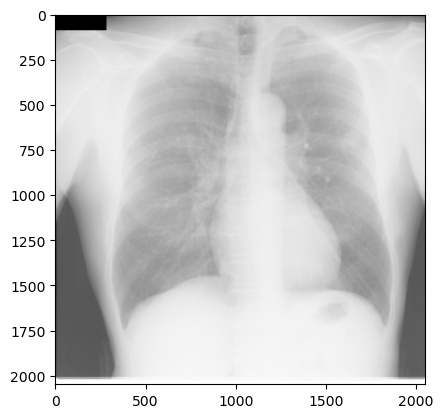

In [17]:
plt.imshow(img)
plt.show()

d:\Study\Conda Projects\iaiJSRT\JSRT/jsrt_images/images\JPCLN034.IMG.png


C:\Users\anish\AppData\Local\Temp\ipykernel_2152\324683092.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


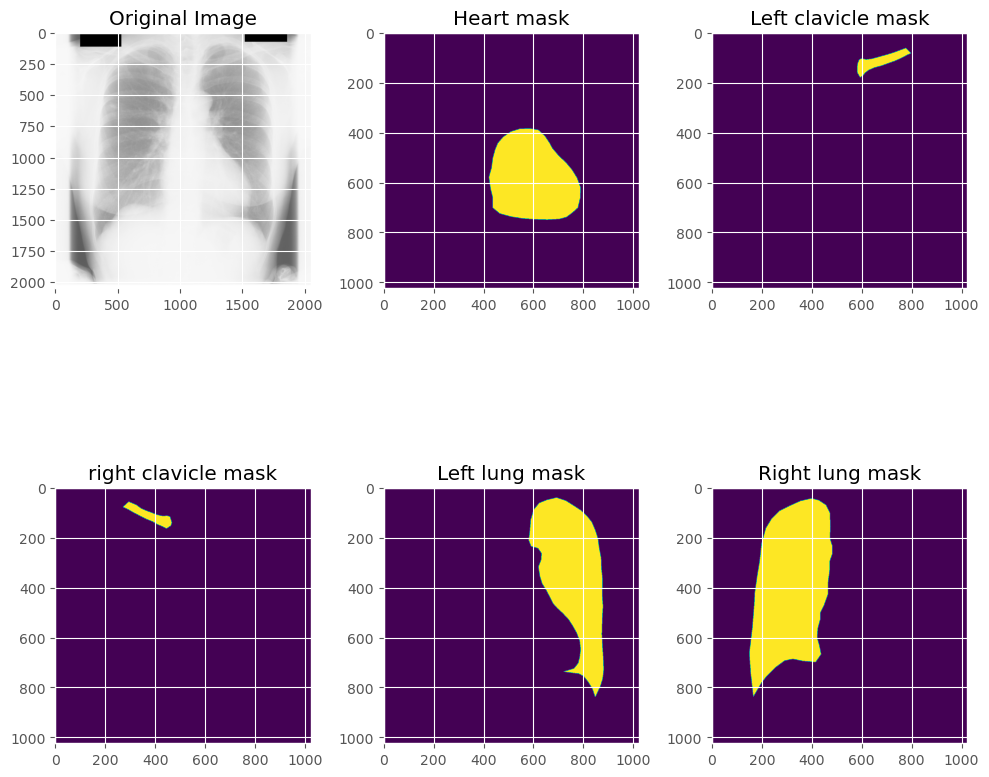

In [78]:
for x in range(1):
    x = trainImages[33]
    print(x)
    img = cv2.imread(x)
    masks_names = os.path.basename(x).split('.')[0]
    masks_names += '.png'
    heart_mask = cv2.imread(os.path.join(heart_masks_path,masks_names),0)
    left_clavicle_mask = cv2.imread(os.path.join(left_clavicle_path,masks_names),0)
    right_cavicle_mask = cv2.imread(os.path.join(right_clavicle_path,masks_names),0)
    left_lung_mask = cv2.imread(os.path.join(left_lung_path,masks_names),0)
    right_lung_mask = cv2.imread(os.path.join(right_lung_path,masks_names),0)
    # transforms
    # heart_mask = transforms(heart_mask)
    # left_lung_mask = transforms(left_lung_mask)
    # right_lung_mask = transforms(right_lung_mask)
    # left_clavicle_mask = transforms(left_clavicle_mask)
    # right_cavicle_mask = transforms(right_cavicle_mask) 
    # orig_mask = torch.stack([heart_mask,left_clavicle_mask,right_cavicle_mask,left_lung_mask,right_lung_mask])
    # orig_mask = torch.from_numpy(orig_mask)
    #orig_mask = transforms(orig_mask)
    # print(orig_mask.shape)

    figure, ax = plt.subplots(nrows=2,ncols=3, figsize=(10,10))

    ax[0][0].imshow(img)
    ax[0][1].imshow(heart_mask)
    ax[0][2].imshow(left_clavicle_mask)
    ax[1][0].imshow(right_cavicle_mask)
    ax[1][1].imshow(left_lung_mask)
    ax[1][2].imshow(right_lung_mask)

    ax[0][0].set_title("Original Image")
    ax[0][1].set_title("Heart mask")
    ax[0][2].set_title("Left clavicle mask")
    ax[1][0].set_title("right clavicle mask")
    ax[1][1].set_title("Left lung mask")
    ax[1][2].set_title("Right lung mask")

    figure.tight_layout()
    figure.show()

In [22]:
maskPaths = [heartMasks,
leftClavicleMasks,
rightClavicleMasks,
leftLungMasks,
rightLungMasks]

In [16]:
class segmentationDataset(Dataset):
    def __init__(self,imagePaths, maskPaths, transforms) -> None:
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.imagePaths)
    
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]

        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        heart_mask = cv2.imread(self.maskPaths[0][index],0)
        left_clavicle_mask = cv2.imread(self.maskPaths[1][index],0)
        right_cavicle_mask = cv2.imread(self.maskPaths[2][index],0)
        left_lung_mask = cv2.imread(self.maskPaths[3][index],0)
        right_lung_mask = cv2.imread(self.maskPaths[4][index],0)

        if self.transforms is not None:
            image = self.transforms(image)
            heart_mask = self.transforms(heart_mask)
            left_clavicle_mask = self.transforms(left_clavicle_mask)
            right_cavicle_mask = self.transforms(right_cavicle_mask)
            left_lung_mask = self.transforms(left_lung_mask)
            right_lung_mask = self.transforms(right_lung_mask)
            
            mask = torch.stack([heart_mask,left_clavicle_mask,right_cavicle_mask,left_lung_mask,right_lung_mask]) 
        
        return (image, mask)

In [17]:
import segmentation_models_pytorch as smp

In [21]:
model = smp.Unet(
    encoder_name = "resnet18",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 5,
    activation = None
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
split = train_test_split(trainImages, maskPaths, test_size=0.2, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

In [23]:
trainDS = segmentationDataset(imagePaths=trainImages,maskPaths=maskPaths, transforms=transforms)
#testDS = segmentationDataset(imagePaths=testImages,maskPaths=testMasks,transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
#print(f"[INFO] found {len(testDS)} examples in the test set...")

[INFO] found 247 examples in the training set...


In [24]:
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
# testLoader = DataLoader(testDS, shuffle=True, batch_size=batch_size)

In [25]:
opt = Adam(model.parameters(),lr=init_lr)

In [26]:
trainSteps = len(trainDS)//batch_size
# testSteps = len(testDS)//batch_size

In [27]:
metrics = {"dice_loss_train":[],"dice_loss_test":[],"jloss_train":[],"jloss_test":[],"iou_train":[],"iou_test":[]}

In [28]:
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.losses import JaccardLoss
import time

In [29]:
dLoss = DiceLoss('binary')
jLoss = JaccardLoss('binary')

In [30]:
from torchmetrics import JaccardIndex
iou = JaccardIndex("multiclass",num_classes=2)

In [31]:
print("[INFO] Training the network.")

startTime = time.time()

for e in tqdm(range(num_epochs)):
    model.train()

    totalTrainLoss = 0
    totalTrainLossDice = 0
    totalTrainLossJac = 0
    totalTrainIoU = 0

    for (i,(x,y)) in enumerate(trainLoader):
        (x,y) = (x.to(device),y.to(device))

        pred = model(x)
        diceLoss = dLoss(pred,y)
        jaccardLoss = jLoss(pred,y)
        # pred_iou = torch.squeeze(pred)
        # y_iou = torch.squeeze(y)
        # print(pred_iou.shape, y_iou.shape)
        # iou_index = iou(pred_iou,y_iou)

        opt.zero_grad()
        diceLoss.backward()
        opt.step()

        totalTrainLossDice += diceLoss
        totalTrainLossJac += jaccardLoss
        # totalTrainIoU += iou_index

    avgTrainLossDice = totalTrainLossDice/trainSteps

    avgTrainLossJacc = totalTrainLossJac/trainSteps

    # avgTrainLossIoU = totalTrainIoU/trainSteps

    # update our training history
    metrics["dice_loss_train"].append(avgTrainLossDice.cpu().detach().numpy())
    
    metrics["jloss_train"].append(avgTrainLossJacc.cpu().detach().numpy())

    # metrics["iou_train"].append(avgTrainLossIoU.cpu().detach().numpy())
    
	# print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Dice Train Loss:{:.4f}, Jaccard Loss Train:{:.4f}".format(
		avgTrainLossDice,avgTrainLossJacc))
        
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))



[INFO] Training the network.


 10%|█         | 1/10 [00:27<04:03, 27.03s/it]

[INFO] EPOCH: 1/10
Dice Train Loss:0.7753, Jaccard Loss Train:0.8803


 20%|██        | 2/10 [00:48<03:07, 23.48s/it]

[INFO] EPOCH: 2/10
Dice Train Loss:0.6852, Jaccard Loss Train:0.8196


 30%|███       | 3/10 [01:08<02:36, 22.34s/it]

[INFO] EPOCH: 3/10
Dice Train Loss:0.6180, Jaccard Loss Train:0.7693


 40%|████      | 4/10 [01:29<02:10, 21.68s/it]

[INFO] EPOCH: 4/10
Dice Train Loss:0.5391, Jaccard Loss Train:0.7051


 50%|█████     | 5/10 [01:50<01:46, 21.39s/it]

[INFO] EPOCH: 5/10
Dice Train Loss:0.4541, Jaccard Loss Train:0.6278


 60%|██████    | 6/10 [02:11<01:25, 21.39s/it]

[INFO] EPOCH: 6/10
Dice Train Loss:0.3683, Jaccard Loss Train:0.5404


 70%|███████   | 7/10 [02:33<01:04, 21.37s/it]

[INFO] EPOCH: 7/10
Dice Train Loss:0.2969, Jaccard Loss Train:0.4595


 80%|████████  | 8/10 [02:54<00:42, 21.35s/it]

[INFO] EPOCH: 8/10
Dice Train Loss:0.2390, Jaccard Loss Train:0.3869


 90%|█████████ | 9/10 [03:15<00:21, 21.27s/it]

[INFO] EPOCH: 9/10
Dice Train Loss:0.1981, Jaccard Loss Train:0.3313


100%|██████████| 10/10 [03:37<00:00, 21.70s/it]

[INFO] EPOCH: 10/10
Dice Train Loss:0.1660, Jaccard Loss Train:0.2853
[INFO] total time taken to train the model: 217.02s


In [32]:
torch.save(model,model_path)

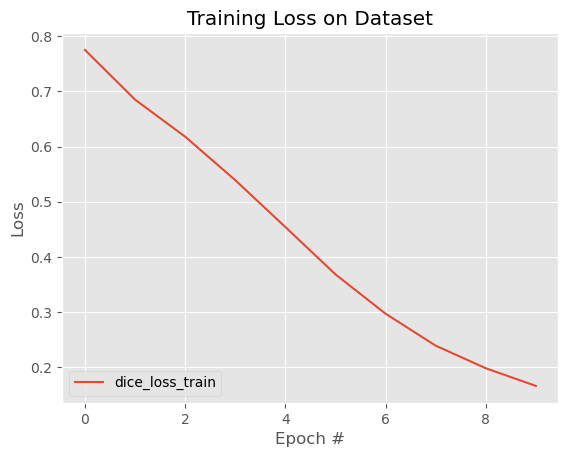

In [33]:
plt.style.use("ggplot")
plt.figure()
plt.plot(metrics["dice_loss_train"], label="dice_loss_train")
# plt.plot(metrics["dice_loss_test"], label="dice_loss_test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_dice_path)

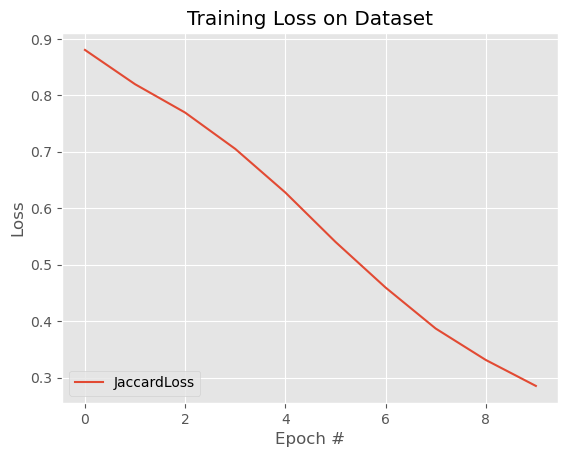

In [34]:
plt.style.use("ggplot")
plt.figure()
plt.plot(metrics["jloss_train"], label="JaccardLoss")
# plt.plot(metrics["IoU_test"], label="IoU_test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_iou_path)

### Testing the model

In [23]:
model = torch.load(model_path)

In [19]:
def prepare_plot(origImage,origMask, predMask):
    plt.grid(None)
    figure, ax = plt.subplots(nrows=3,ncols=4, figsize=(10,10))

    ax[0][0].imshow(origImage)
    ax[0][1].imshow(origMask[0])
    ax[0][2].imshow(predMask[0])
    ax[0][3].imshow(origMask[1])
    ax[1][0].imshow(predMask[1])
    ax[1][1].imshow(origMask[2])
    ax[1][2].imshow(predMask[2])
    ax[1][3].imshow(origMask[3])
    ax[2][0].imshow(predMask[3])
    ax[2][1].imshow(origMask[4])
    ax[2][2].imshow(predMask[4])
    

    ax[0][0].set_title("Original Image")
    ax[0][1].set_title("Original mask: heart mask")
    ax[0][2].set_title("Predicted mask: heart mask")
    ax[0][3].set_title("Original mask: left clavicle mask")
    ax[1][0].set_title("Predicted mask: left clavicle mask")
    ax[1][1].set_title("Original mask: right clavicle mask")
    ax[1][2].set_title("Predicted mask: right clavicle mask")
    ax[1][3].set_title("Original mask: left lung mask")
    ax[2][0].set_title("Predicted mask: left lung mask")
    ax[2][1].set_title("Original mask: right lung mask")
    ax[2][2].set_title("Predicted mask: right lung mask")

    figure.tight_layout()
    figure.show()

In [20]:
def prepare_plot(origImage,origMask, predMask):
    # figure, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,10))
    figure_h, ax_h = plt.subplots(nrows=1,ncols=3, figsize=(10,10))
    figure_lc, ax_lc = plt.subplots(nrows=1,ncols=3, figsize=(10,10))
    figure_rc, ax_rc = plt.subplots(nrows=1,ncols=3, figsize=(10,10))
    figure_ll, ax_ll = plt.subplots(nrows=1,ncols=3, figsize=(10,10))
    figure_rl, ax_rl = plt.subplots(nrows=1,ncols=3, figsize=(10,10))
    

    ax_h[0].imshow(origImage)
    ax_h[1].imshow(origMask[0])
    ax_h[2].imshow(predMask[0])
    ax_lc[0].imshow(origImage)
    ax_lc[1].imshow(origMask[1])
    ax_lc[2].imshow(predMask[1])
    ax_rc[0].imshow(origImage)
    ax_rc[1].imshow(origMask[2])
    ax_rc[2].imshow(predMask[2])
    ax_ll[0].imshow(origImage)
    ax_ll[1].imshow(origMask[3])
    ax_ll[2].imshow(predMask[3])
    ax_rl[0].imshow(origImage)
    ax_rl[1].imshow(origMask[4])
    ax_rl[2].imshow(predMask[4])
    

    ax_h[0].set_title("Original Image")
    ax_h[1].set_title("Original mask: heart mask")
    ax_h[2].set_title("Predicted mask: heart mask")
    ax_lc[0].set_title("Original Image")
    ax_lc[1].set_title("Original mask: left clavicle mask")
    ax_lc[2].set_title("Predicted mask: left clavicle mask")
    ax_rc[0].set_title("Original Image")
    ax_rc[1].set_title("Original mask: right clavicle mask")
    ax_rc[2].set_title("Predicted mask: right clavicle mask")
    ax_ll[0].set_title("Original Image")
    ax_ll[1].set_title("Original mask: left lung mask")
    ax_ll[2].set_title("Predicted mask: left lung mask")
    ax_rl[0].set_title("Original Image")
    ax_rl[1].set_title("Original mask: right lung mask")
    ax_rl[2].set_title("Predicted mask: right lung mask")

    figure_h.tight_layout()
    figure_h.show()
    figure_lc.tight_layout()
    figure_lc.show()
    figure_rc.tight_layout()
    figure_rc.show()
    figure_ll.tight_layout()
    figure_ll.show()
    figure_rl.tight_layout()
    figure_rl.show()

In [21]:
def make_predictions(model,imagePath):

    model.eval()

    with torch.no_grad():
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image.astype("float32")/255.0

        image = cv2.resize(image,(256,256))

        orig = image.copy()

        masks_names = os.path.basename(imagePath).split('.')[0]
        masks_names += '.png'
        heart_mask = cv2.imread(os.path.join(heart_masks_path,masks_names),0)
        left_clavicle_mask = cv2.imread(os.path.join(left_clavicle_path,masks_names),0)
        right_cavicle_mask = cv2.imread(os.path.join(right_clavicle_path,masks_names),0)
        left_lung_mask = cv2.imread(os.path.join(left_lung_path,masks_names),0)
        right_lung_mask = cv2.imread(os.path.join(right_lung_path,masks_names),0)

        heart_mask = cv2.resize(heart_mask,(input_image_height,input_image_width))
        left_clavicle_mask = cv2.resize(left_clavicle_mask,(input_image_height,input_image_width))
        right_cavicle_mask = cv2.resize(right_cavicle_mask,(input_image_height,input_image_width))
        left_lung_mask = cv2.resize(left_lung_mask,(input_image_height,input_image_width))
        right_lung_mask = cv2.resize(right_lung_mask,(input_image_height,input_image_width))
        gtMask = np.stack([heart_mask,left_clavicle_mask,right_cavicle_mask,left_lung_mask,right_lung_mask],0)

        image = np.transpose(image,[2,0,1])
        image = np.expand_dims(image,0)
        image = torch.from_numpy(image).to(device)

        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()

        predMask[0] = (predMask[0]>threshold)*255
        predMask[1] = (predMask[1]>0.1)*255
        predMask[2] = (predMask[2]>0.05)*255
        predMask[3] = (predMask[3]>threshold)*255
        predMask[4] = (predMask[4]>threshold)*255

        prepare_plot(orig,gtMask,predMask)
        

C:\Users\anish\AppData\Local\Temp\ipykernel_10492\2358569041.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_h.show()
C:\Users\anish\AppData\Local\Temp\ipykernel_10492\2358569041.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_lc.show()
C:\Users\anish\AppData\Local\Temp\ipykernel_10492\2358569041.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_rc.show()
C:\Users\anish\AppData\Local\Temp\ipykernel_10492\2358569041.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_ll.show()
C:\Users\anish\AppData\Local\Temp\ipykernel_10492\2358569041.py:52: UserWarning: Matplotl

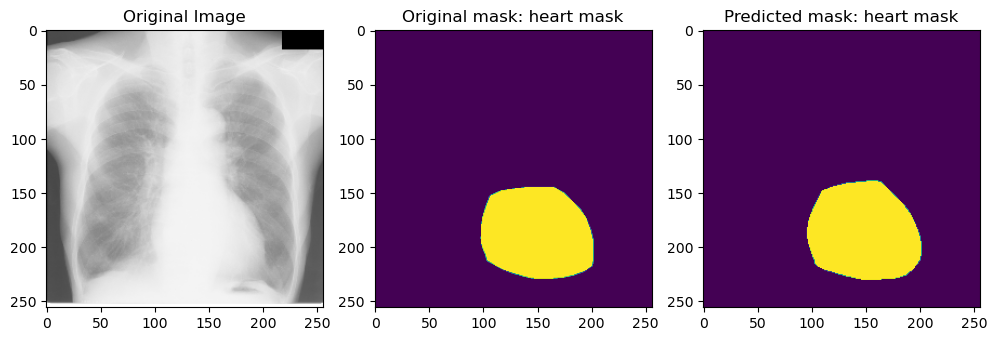

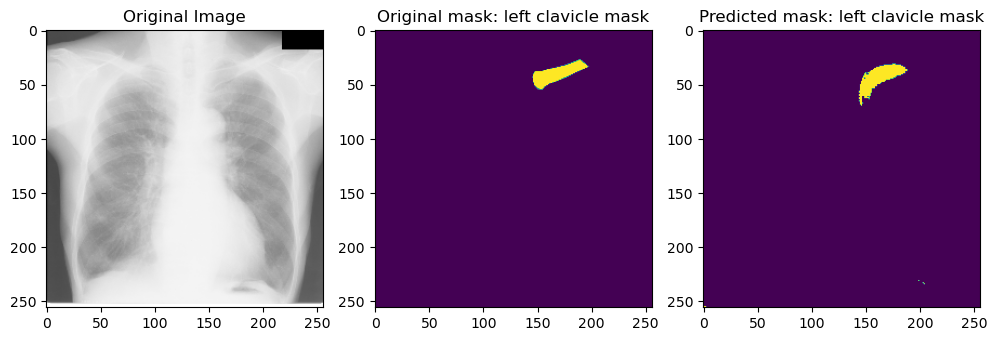

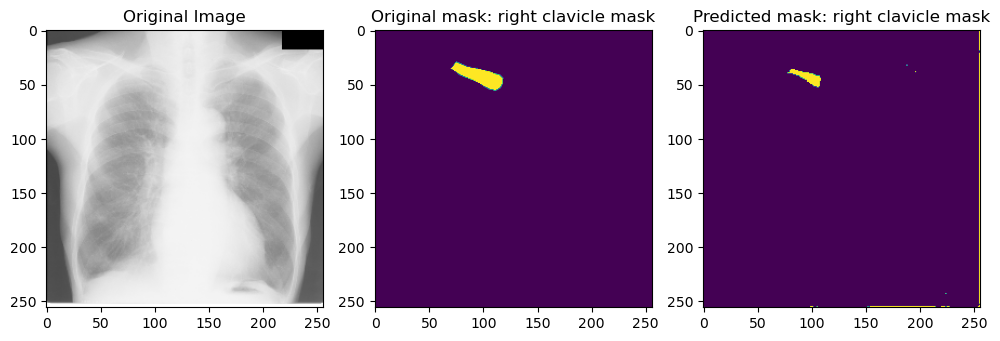

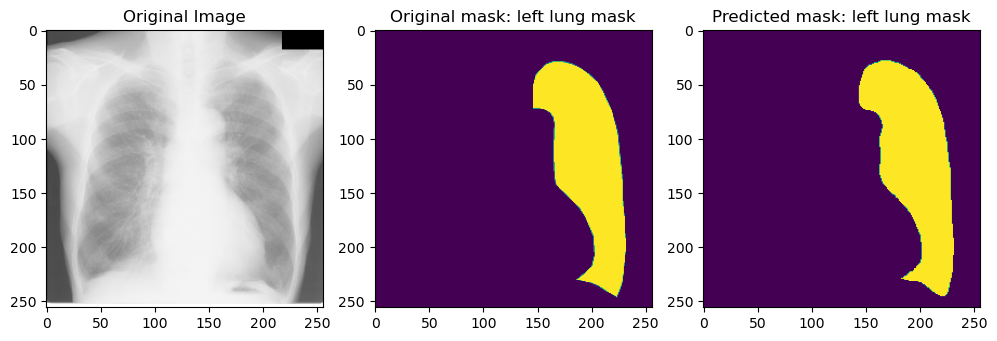

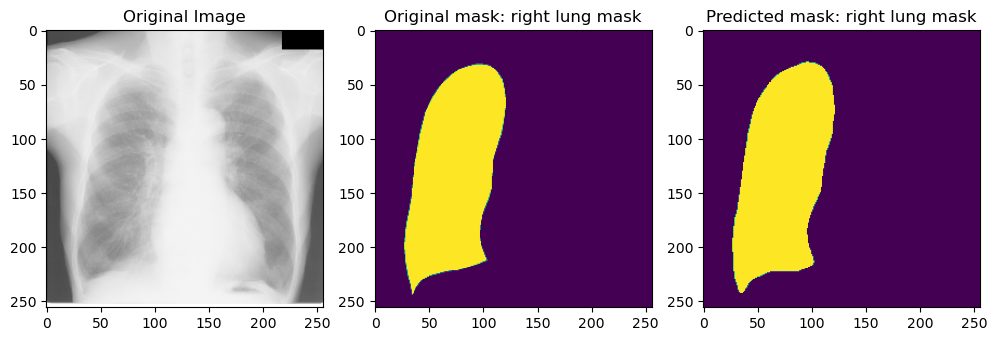

In [24]:
make_predictions(model, "D:\Study\Conda Projects\iaiJSRT\JSRT\jsrt_images\images\JPCLN047.IMG.png")

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='Average ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()